# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

## Loading Data Files

In [2]:
folder_path = '../data/_MVC/_test'  # dataset folder path
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
dataframes = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    file_id = os.path.splitext(file)[0]
    df = pd.read_csv(file_path, skiprows=8, header=None, usecols=range(32))
    columns_to_keep = list(range(4)) + [i for i in range(5, df.shape[1]) if i % 2 == 1]
    df = df.iloc[:, columns_to_keep]
    dataframes.append(df)

In [3]:
column_names = [
    'EMG_Time', 'Forearm2_EMG_mV',
    'ACC_Time', 'Forearm2_ACC_X_G',
    'Forearm2_ACC_Y_G',
    'Forearm2_ACC_Z_G',

    'Forearm1_EMG_mV',
    'Forearm1_ACC_X_G',
    'Forearm1_ACC_Y_G',
    'Forearm1_ACC_Z_G',

    'Biceps_EMG_mV',
    'Biceps_ACC_X_G',
    'Biceps_ACC_Y_G',
    'Biceps_ACC_Z_G',

    'Triceps_EMG_mV',
    'Triceps_ACC_X_G',
    'Triceps_ACC_Y_G',
    'Triceps_ACC_Z_G',
]

for i, df in enumerate(dataframes):
    if len(column_names) == df.shape[1]:
        df.columns = column_names
print(dataframes[0].head())

   EMG_Time  Forearm2_EMG_mV ACC_Time Forearm2_ACC_X_G Forearm2_ACC_Y_G  \
0  0.000000        -0.009567        0       -0.3540039       -0.9423828   
1  0.000519        -0.008560   0.0135       -0.3569336       -0.9399414   
2  0.001038        -0.003693    0.027       -0.3588867       -0.9428711   
3  0.001558        -0.000168   0.0405       -0.3632812       -0.9428711   
4  0.002077         0.002518    0.054       -0.3637695       -0.9428711   

  Forearm2_ACC_Z_G  Forearm1_EMG_mV Forearm1_ACC_X_G Forearm1_ACC_Y_G  \
0        0.1484375        -0.005203        0.4238281         -0.90625   
1        0.1459961        -0.003861        0.4165039       -0.9072266   
2        0.1450195        -0.004196        0.4140625       -0.9091797   
3        0.1411133        -0.005036        0.4135742       -0.9091797   
4        0.1416016        -0.006043        0.4135742       -0.9116211   

  Forearm1_ACC_Z_G  Biceps_EMG_mV Biceps_ACC_X_G Biceps_ACC_Y_G  \
0       -0.1318359      -0.010239      0.09

In [6]:
Biceps_EMG_mV = dataframes[0]['Biceps_EMG_mV'].to_numpy()
#Triceps_EMG_mV = dataframes[0]['Triceps_EMG_mV'].to_numpy()
EMG_Time = dataframes[0]['EMG_Time'].to_numpy()

In [7]:
def plot_signal(signal, title="Signal"):
    plt.plot(signal)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("mV")
    plt.grid(True)
    plt.show()

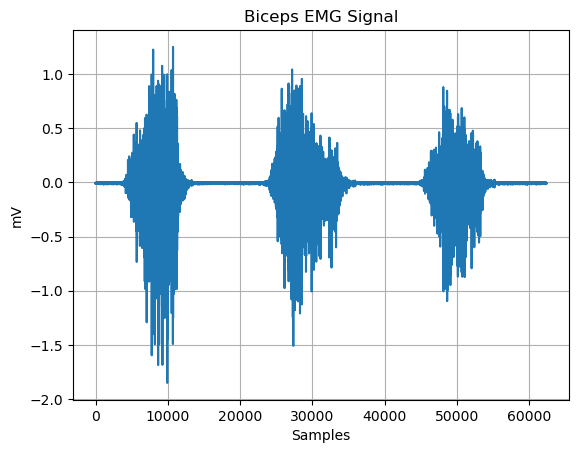

In [8]:
plot_signal(Biceps_EMG_mV, title="Biceps EMG Signal")
#plot_signal(Triceps_EMG_mV, title="Triceps EMG Signal")

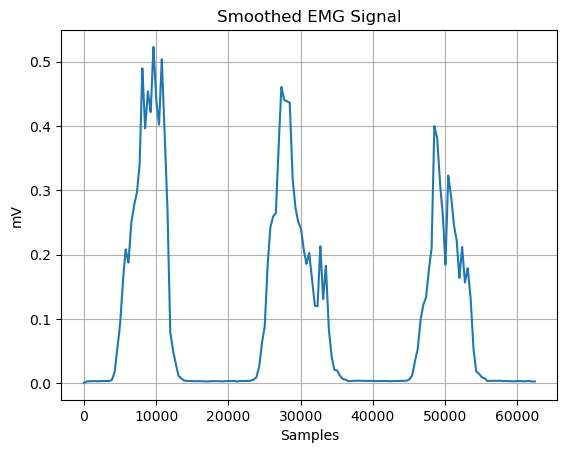

In [10]:
def bandpass_filter(signal, fs, low_freq=20, high_freq=450, order=4):
    b, a = butter(order, [low_freq, high_freq], fs=fs, btype='band')
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

def rectification (signal):
    return np.abs(signal)

def RMS_moving(input_signal, fs, time_window=0.2):
    window_length = int(time_window * fs)
    rms_result = []

    for start_idx in range(0, len(input_signal) - window_length + 1, window_length):
        segment = np.array(input_signal[start_idx:start_idx + window_length])
        rms_value = np.sqrt(np.mean(segment ** 2))
        if rms_result:
            interpolated_values = np.linspace(rms_result[-1], rms_value, window_length)
        else:
            interpolated_values = np.linspace(input_signal[0], rms_value, window_length)
        rms_result.extend(interpolated_values)
        
    # Padding 
    if len(rms_result) < len(input_signal):
        padding_length = len(input_signal) - len(rms_result)
        rms_result = np.concatenate((rms_result, np.full(padding_length, rms_result[-1])))

    return rms_result

dt = np.mean(np.diff(EMG_Time)) 
fs = 1 / dt


Filtered_EMG = bandpass_filter(Biceps_EMG_mV, fs)
#Filtered_EMG = bandpass_filter(Triceps_EMG_mV, fs)
Rectified_EMG = rectification(Filtered_EMG)
Smoothed_EMG = RMS_moving(Rectified_EMG, fs, 0.2)

plot_signal(Smoothed_EMG, title="Smoothed EMG Signal")

In [14]:
def compute_mvc_with_overlap(emg_signal, fs, window_ms=500, overlap_perc=0):
    window_samples = int((window_ms / 1000) * fs)
    step = int(window_samples * (1 - overlap_perc))

    if window_samples > len(emg_signal):
        raise ValueError("Window is larger than signal length")

    max_mean = 0
    for start in range(0, len(emg_signal) - window_samples + 1, step):
        window = emg_signal[start:start + window_samples]
        window_mean = np.mean(window)
        if window_mean > max_mean:
            max_mean = window_mean

    return max_mean

In [15]:
mvc = compute_mvc_with_overlap(Smoothed_EMG, fs)

In [16]:
mvc_dict = {'biceps': mvc}
# Creazione del DataFrame
mvc_df = pd.DataFrame.from_dict(mvc_dict, orient='index', columns=['MVC'])

# Percorso di salvataggio
save_path = '../data/_MVC'
#file_name = 'mvc_biceps.csv'
file_name = 'mvc_biceps.csv'
full_path = os.path.join(save_path, file_name)

# Salva il file CSV
mvc_df.to_csv(full_path)
print(mvc_df)

             MVC
biceps  0.451202
